# Using the Discrete Cosine Transform (DCT) to compress sound

In this Notebook we'll see how the DCT can be used to compress an audio signal (in a lossy way). The ideas applied/mentioned here are the same as the ones used in [MP3](https://en.wikipedia.org/wiki/MP3) or [JPEG](https://en.wikipedia.org/wiki/JPEG).

## The Discrete Cosine Transform

The idea behind the [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform) is the same as the one behind the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform). In our case we have a time-based signal (sound), and we want to represent this time-based signal as a sum of waves, [The Math Trick Behind MP3s, JPEGs, and Homer Simpson’s Face](http://nautil.us/blog/the-math-trick-behind-mp3s-jpegs-and-homer-simpsons-face) explains the idea much better than I would. The article uses the FFT as it's example, but here we'll use the DCT instead, the main reason why is on Wikipedia:

> The DCT, and in particular the DCT-II, is often used in signal and image processing, especially for lossy compression, because it has a strong "energy compaction" property: in typical applications, most of the signal information tends to be concentrated in a few low-frequency components of the DCT.

What this means is that a few low-frequency waves (cosines in our case) will be sufficient to reconstruct a 'good enough' signal. By discarding higher frequency waves, we can compress the signal. Note, the DCT doesn't compress anything on its own, it just transforms a signal into a sum of waves. Then we decide to discard higher frequency waves.

I won't get into the math behind the DCT, I'm merely using it as a tool here.

In [1]:
# We'll start with some imports we'll need later on and setting up a couple parameters

In [2]:
%matplotlib inline

import itertools
import StringIO
import urllib2

import functools32
import IPython
import matplotlib.pyplot as plt
import mdct
import numpy as np
import scipy.io.wavfile
import scipy.fftpack

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
# we're using a wav file as our test file here because wav stores raw/uncompressed data
# if we were to use an MP3 we'd be compressing an already lossily compressed files, creating
# artifacts in the result
url = 'http://homepages.udayton.edu/~hardierc/ece203/flute.wav'

In [5]:
@functools32.lru_cache()
def get_data():
    frequency, data = scipy.io.wavfile.read(StringIO.StringIO(urllib2.urlopen(url).read()))
    data = data / 2.**15
    times = np.arange(0, float(len(data)) / frequency, 1. / frequency)
    return frequency, data, times

In [6]:
def play(data, rate, autoplay=False):
    return IPython.display.Audio(data, autoplay=autoplay, rate=rate)

In [7]:
# frequency is the sampling frequency of the file, in this case, 22.5kHz
# data is the signal/sound we want to compress
frequency, data, times = get_data()

In [8]:
# let's see what this sound like
play(data, frequency)

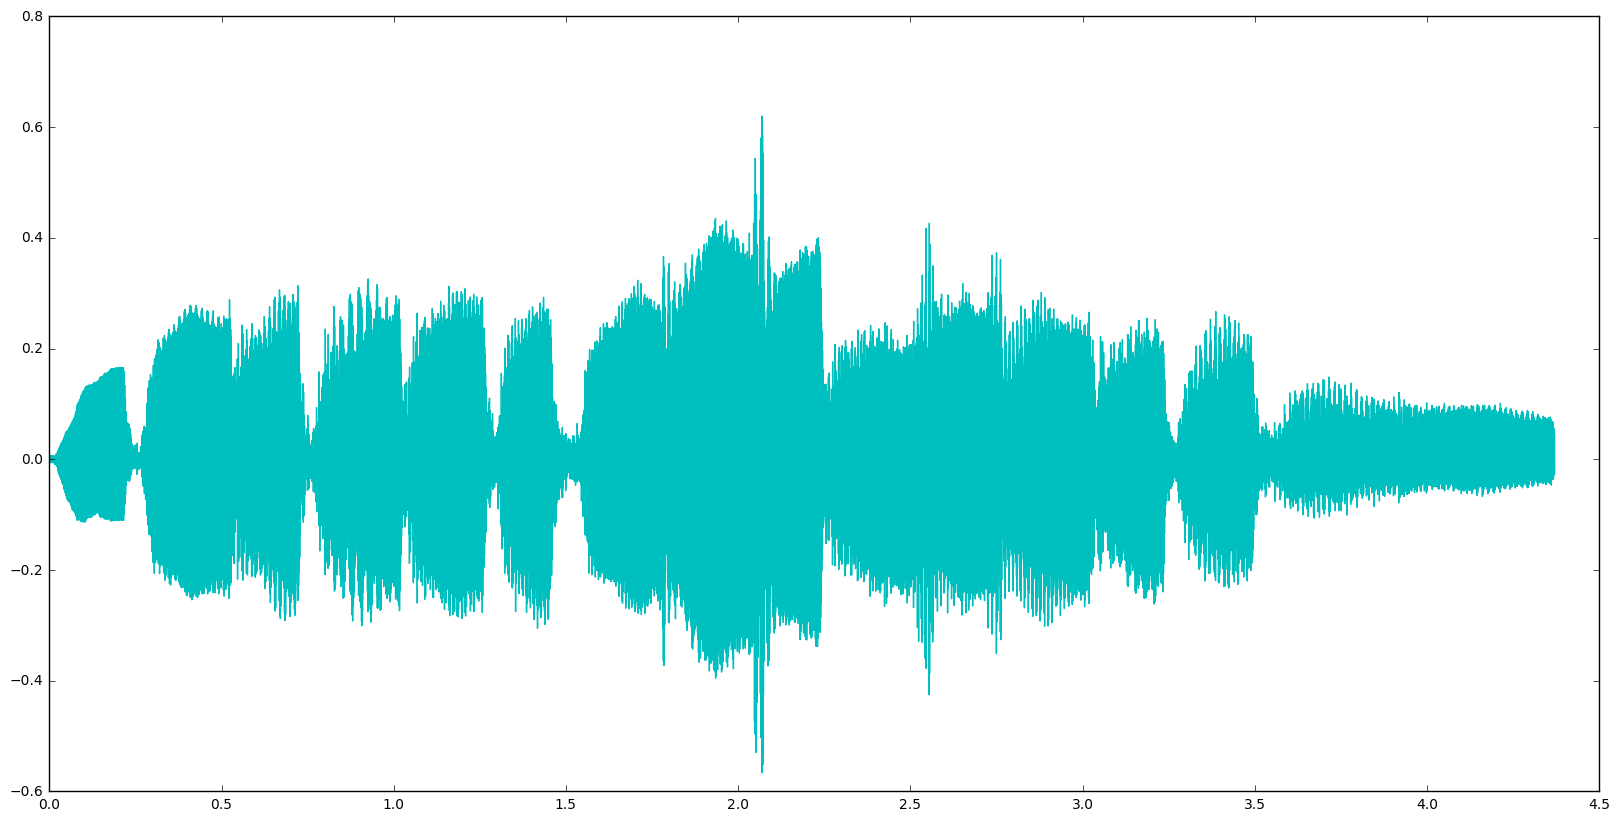

In [9]:
# we can visualize our signal in the time domain
plt.plot(times, data, 'c')

In [10]:
# before going further, we're picking a random sample of the signal so that we can better appreciate
# the effect of the DCT/IDCT
start = 32768
data = data[start:start + 1024]
times = times[start:start + 1024]

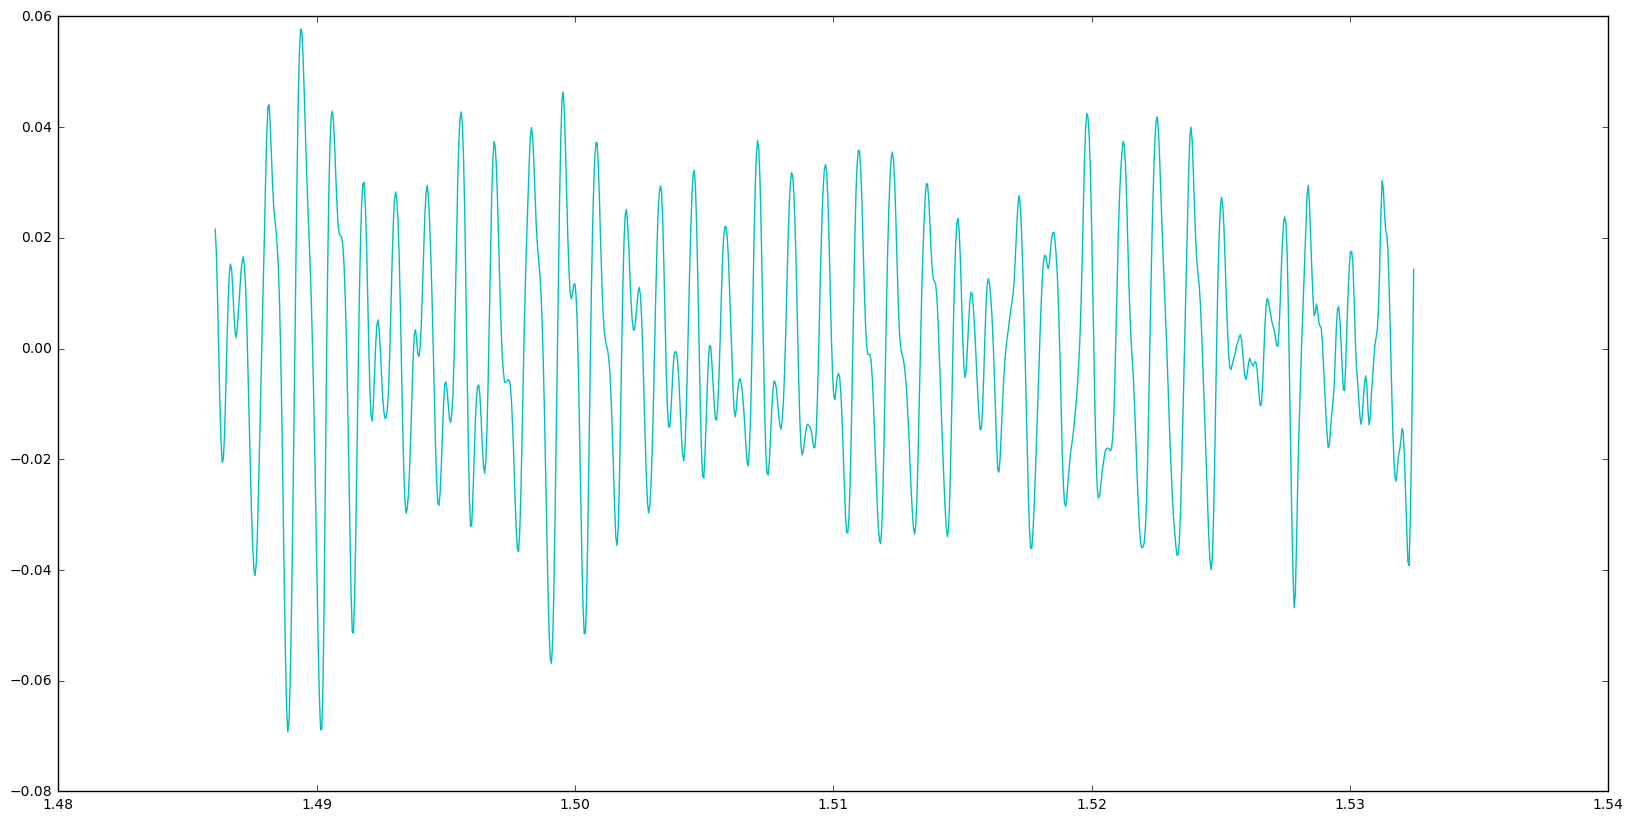

In [11]:
plt.plot(times, data, 'c')

Now that we're done with the setup (acquiring data) we're ready to use the DCT. Below, we're transforming our signal using the DCT, then we discard an increasingly high number of high-frequency cosines, finally we inverse the DCT process.

The cyan signal is the original signal, the magenta signals are the results of reconstructing the signal after going through the inverse DCT process. As we can see the first one is seemingly a perfect representation of the orignal signal, but as we discard more and more high frequency waves, we can see that the quality of our reconstructed signal drops quickly.

Note: here we're simply discarding high frequencies this isn't necessarily the best approach; JPEG for instance uses [quantization](https://en.wikipedia.org/wiki/Quantization_(image_processing%29) to decide which waves to keep/discard. We can discard high frequencies because (1) they can't be heard by the human ear, (2) the DCT packs most information in the low frequency waves. Once discarded/set to 0, the resulting vector can be compressed with [Hufman coding](https://en.wikipedia.org/wiki/Huffman_coding) (all the zeros will compress very well) and/or [Run-length encoding](https://en.wikipedia.org/wiki/Run-length_encoding). This [video](https://www.youtube.com/watch?v=Q2aEzeMDHMA) goes into more details and shows how JPEG uses a clever zig-zag trick to create longer runs of zeros. <https://en.wikipedia.org/wiki/JPEG#Quantization> and <https://en.wikipedia.org/wiki/JPEG#Entropy_coding> are also good reads.

Note: This notebook doesn't actually does the compression step, it's only here to show how we get there (since the compression step on its own isn't that interesting here).

In [12]:
dct = scipy.fftpack.dct(data, norm='ortho')
datas = []

for n in (1024, 128, 64, 32):
    dct[n:] = 0
    datas.append(scipy.fftpack.idct(dct, norm='ortho'))

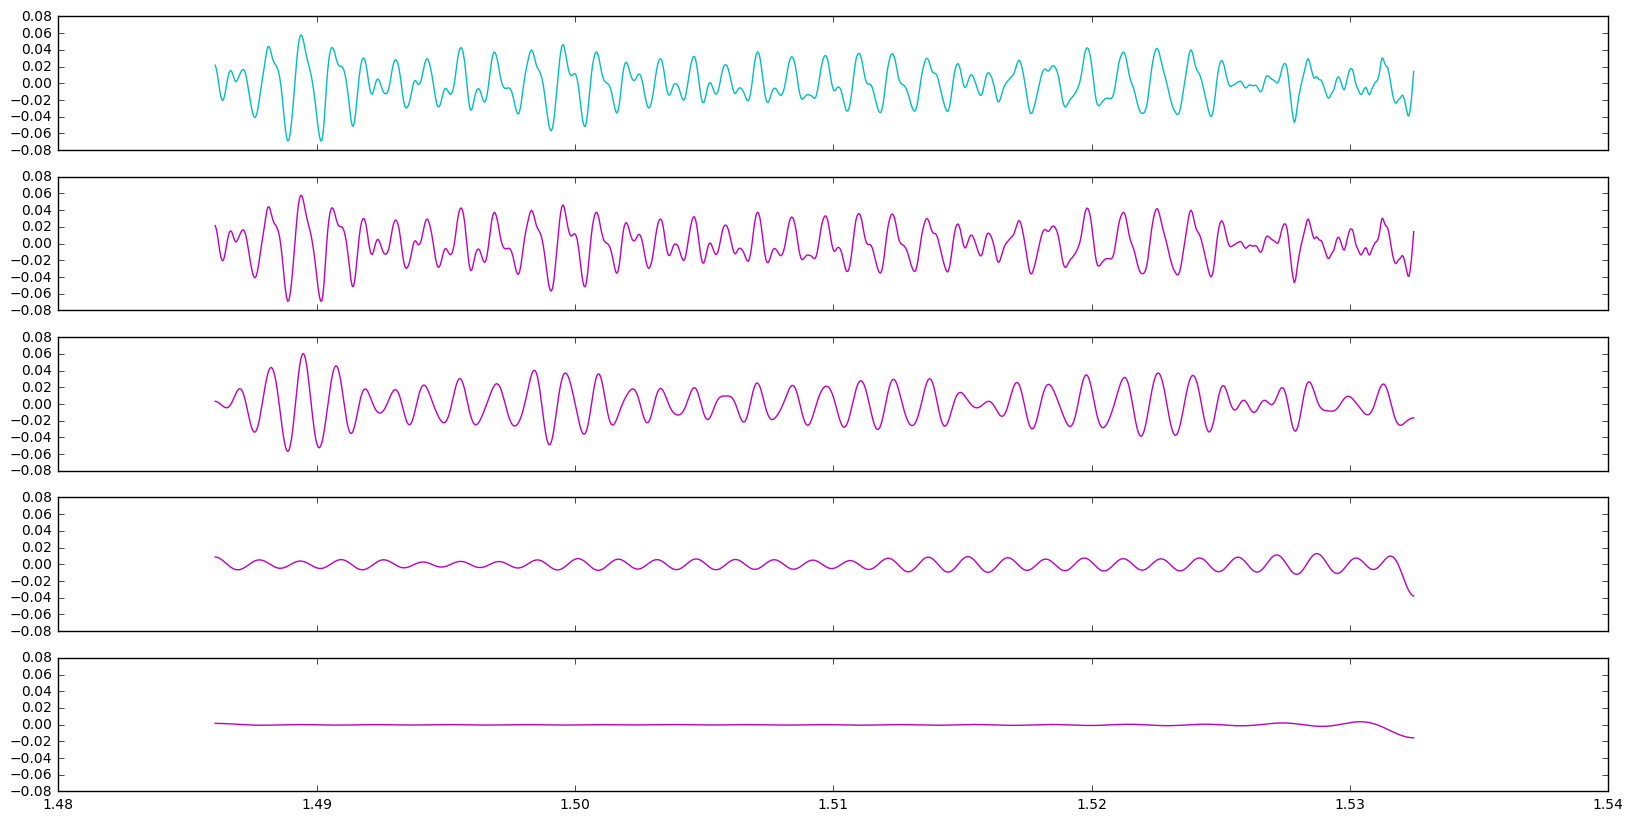

In [13]:
fig, axarr = plt.subplots(len(datas) + 1, sharex=True, sharey=True)

axarr[0].plot(times, data, 'c')

for i, data in enumerate(datas, start=1):
    axarr[i].plot(times, data, 'm')

Now that we've "compressed" (remember we're barely dropping high frequencies here) a sample of our signal we can try to apply the same technique to the whole signal. To do this, we'll convert `data` to chunk of 1024 points, and compress each one of those chunks in sequence, using the same logic as above.

In [14]:
frequency, data, times = get_data()

In [15]:
# https://docs.python.org/2.7/library/itertools.html#itertools-recipes

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return itertools.izip_longest(fillvalue=fillvalue, *args)

In [16]:
samples = 1024
keep = 128

chunks = grouper(data, samples)

transformed = []
for chunk in chunks:
    if None in chunk:
        chunk = chunk[:chunk.index(None)]
    dct = scipy.fftpack.dct(chunk, norm='ortho')
    dct[keep:] = 0
    idct = scipy.fftpack.idct(dct, norm='ortho')
    transformed.append(idct)

result = np.concatenate(transformed)

In [17]:
len(data), len(result)

(96375, 96375)

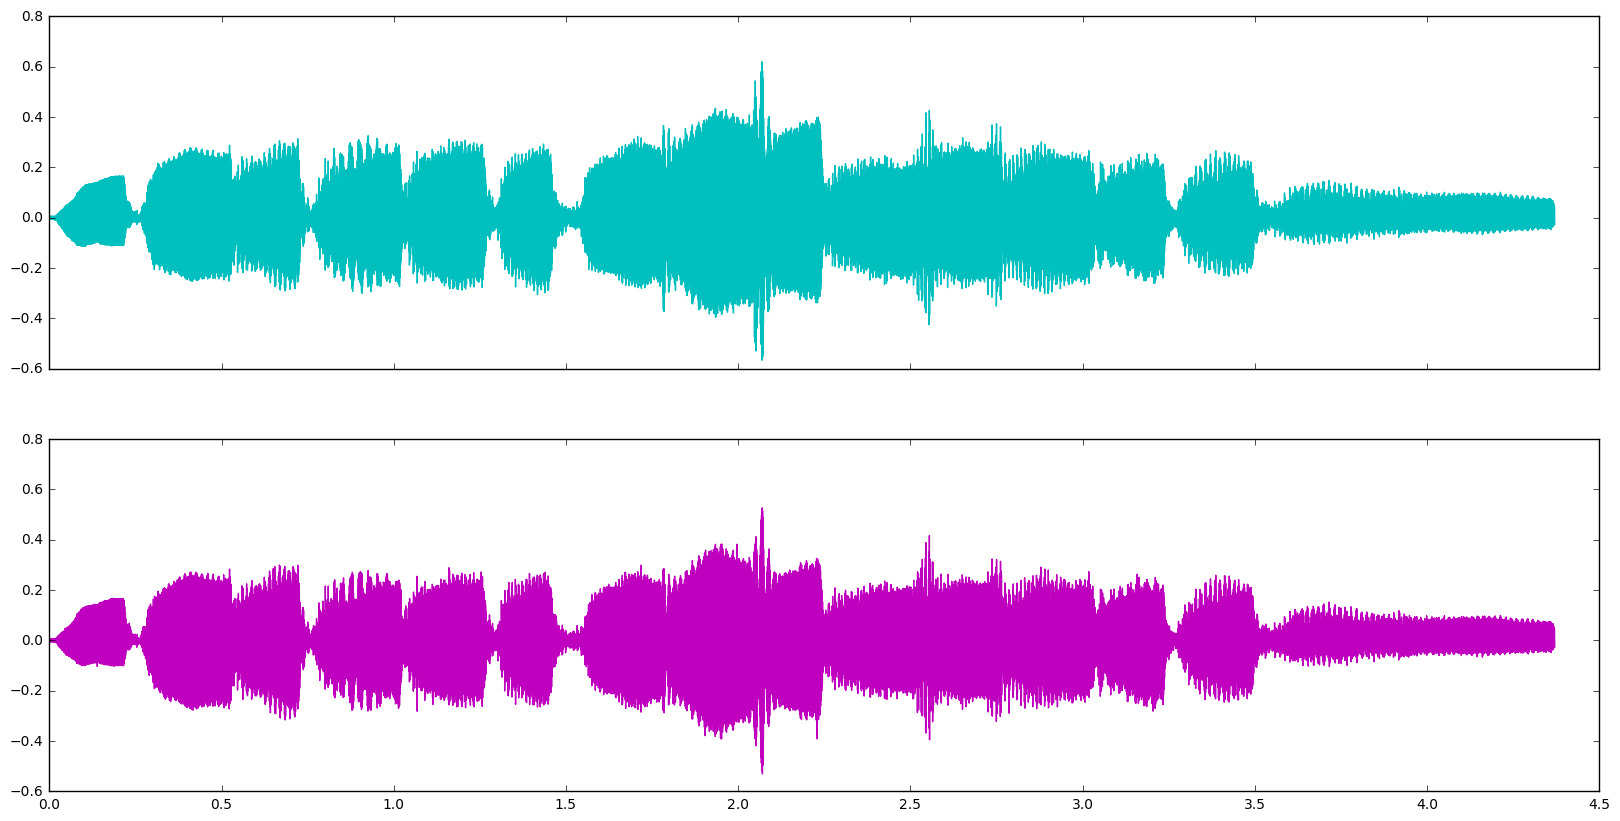

In [18]:
# let's compare our original signal (cyan) with the transformed one (magenta)
# it looks pretty similar!
fig, axarr = plt.subplots(2, sharex=True, sharey=True)

axarr[0].plot(times, data, 'c')
axarr[1].plot(times, result, 'm')

Let's compare how the orignal/reconstructed signal sound!

In [19]:
play(data, frequency)

In [20]:
play(result, frequency)

This sounds _almost_ the same. Almost.

As you noticed our reconstructed signal has some artifacts. The reason for this is simple, each chunk is transformed individually, so chunk boundaries may not line up properly, as we can see on the graph below. We can see that the cyan line (original signal) is smooth around the block boundary, while our reconstructed signal jumps a bit on the block boundary.

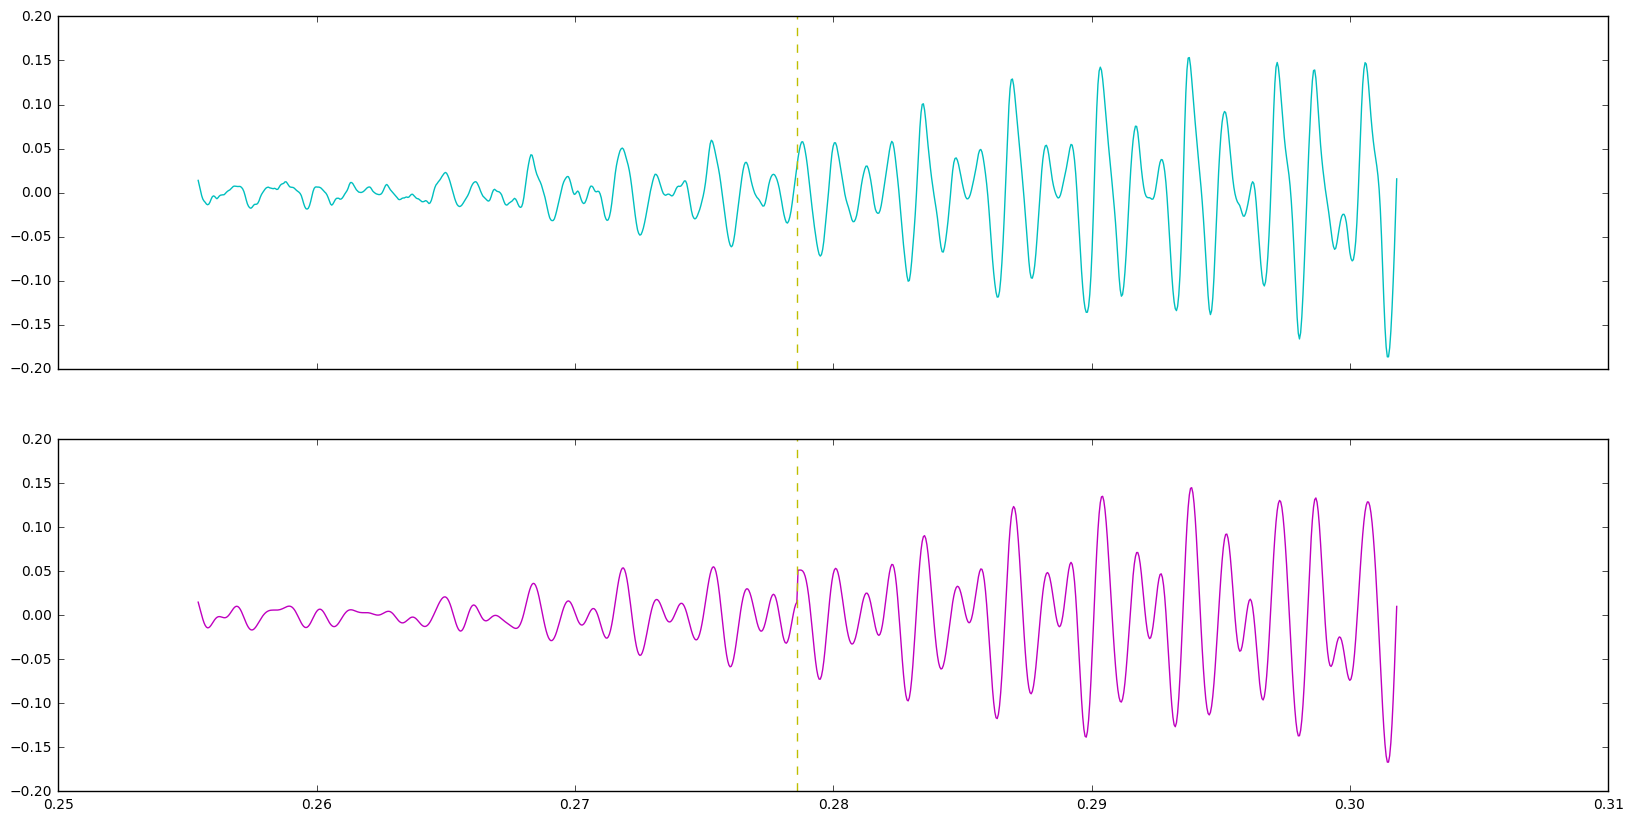

In [21]:
fig, axarr = plt.subplots(2, sharex=True, sharey=True)

r = 6144  # nothing special about this, except that we can clearly see the jump
s = r - 512
e = r + 512

axarr[0].plot(times[s:e], data[s:e], 'c')
axarr[0].axvline(x=times[r - 1], c='y', ls='--')
axarr[1].plot(times[s:e], result[s:e], 'm')
axarr[1].axvline(x=times[r - 1], c='y', ls='--')

But MP3s don't have artifacts? How come?

In practice MP3 doesn't use the DCT, but a modified version, called the [Modified Discrete Cosine Transform](https://en.wikipedia.org/wiki/Modified_discrete_cosine_transform) (MDCT). Again Wikipedia explains better than I would:

> The modified discrete cosine transform (MDCT) is a lapped transform based on the type-IV discrete cosine transform (DCT-IV), with the additional property of being lapped: it is designed to be performed on consecutive blocks of a larger dataset, where subsequent blocks are overlapped so that the last half of one block coincides with the first half of the next block. This overlapping, in addition to the energy-compaction qualities of the DCT, makes the MDCT especially attractive for signal compression applications, since it helps to avoid artifacts stemming from the block boundaries.

Let's use the MDCT and see if the artifacts go away.

In [22]:
frequency, data, times = get_data()

In [23]:
transformed = mdct.mdct(data, framelength=2048)

# drop higher frequencies
for i in range(128, len(transformed)):
    transformed[i][:] = 0

reconstructed = mdct.imdct(transformed, framelength=2048)

If we plot the same chunk boundary again, we can see that the signal reconstructed from the MDCT transform (green) doesn't show the jump present in the regular DCT'd signal (magenta).

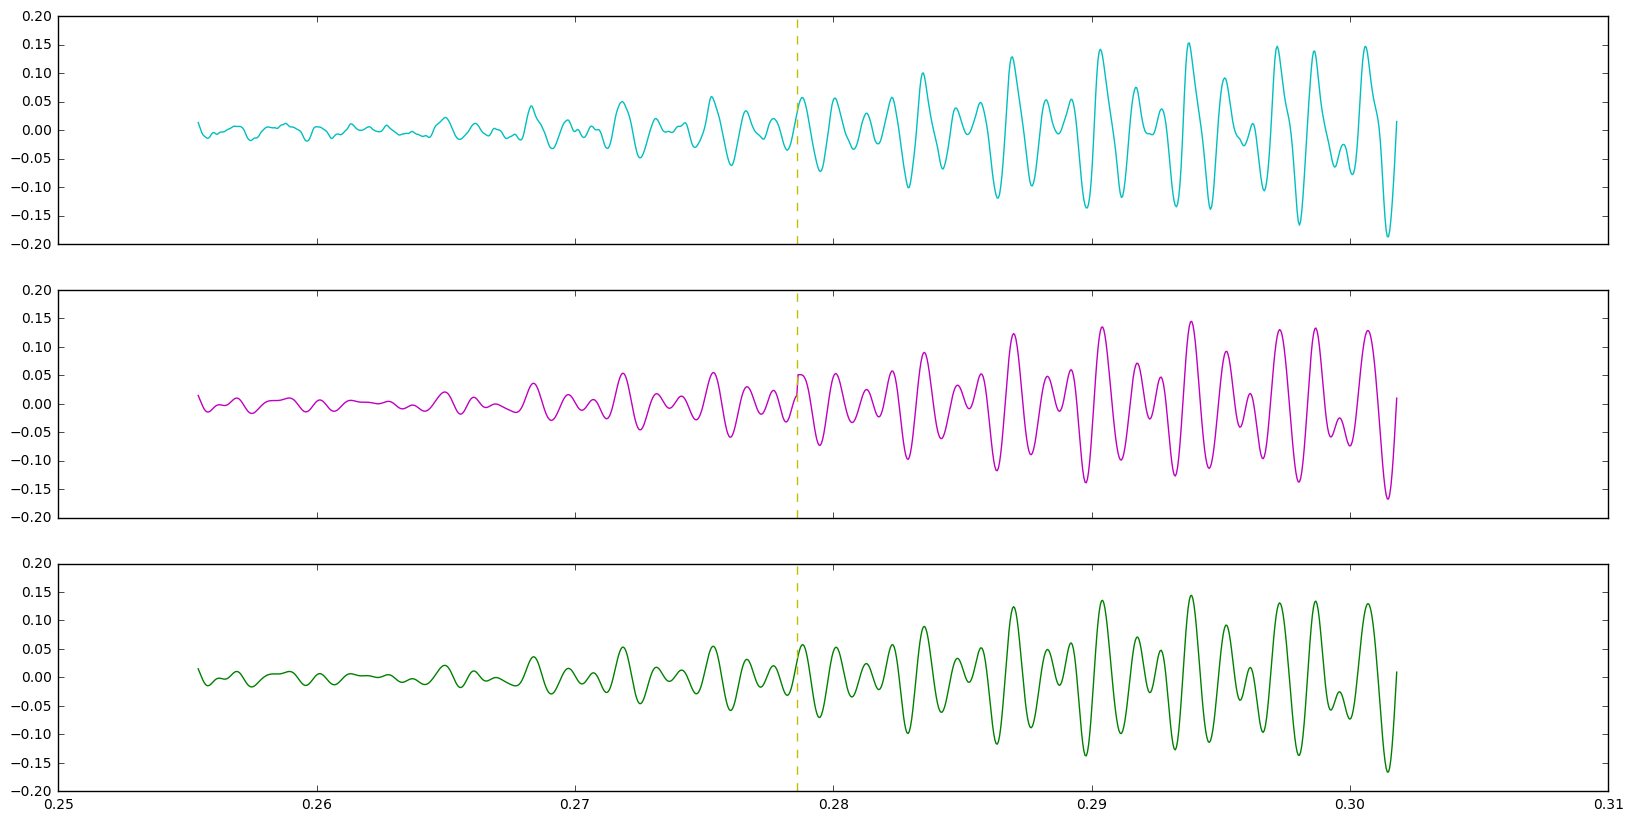

In [24]:
fig, axarr = plt.subplots(3, sharex=True, sharey=True)

r = 6144
s = r - 512
e = r + 512

axarr[0].plot(times[s:e], data[s:e], 'c')
axarr[0].axvline(x=times[r - 1], c='y', ls='--')
axarr[1].plot(times[s:e], result[s:e], 'm')
axarr[1].axvline(x=times[r - 1], c='y', ls='--')
axarr[2].plot(times[s:e], reconstructed[s:e], 'g')
axarr[2].axvline(x=times[r - 1], c='y', ls='--')

But the best way to see if we got rid of the artifacts is still to listen to the result...

In [25]:
play(reconstructed, frequency)